# Exercise 4: Single scattering properties in Mie and Rayleight regimes  


This execise is about the comparison between the scattering properties in MW of various Hydrometeors (cloud and precipitaiton particles) comparing the results form the Mie and Rayleigh regime.

The student is asked to answer some questions after completing the notebook.






If miepython is not installed, uncomment the following cell (i.e., delete the #) and run (shift-enter)

In [50]:
# !pip install miepython

In [10]:
import numpy as np
import matplotlib.pyplot as plt

try:
    import miepython

except ModuleNotFoundError:
    print('miepython not installed. To install, uncomment and run the cell above.')
    print('Once installation is successful, rerun this cell again.')

In [11]:
import miepython

import numpy as np
import matplotlib.pyplot as plt

## Sign Convention
The sign of the imaginary part of the index of refraction in miepython is assumed negative (as shown above). This convention is standard for atmospheric science and follows that of van de Hulst.


## Rayleigh Scattering Functions

These functions calculates the Rayleigh efficiencies (exintion qext, scattering qsca, backscattering qback) and the asymetry factor. Moreover the Amplitude Functions (S1 and S2) that are needed to calculate the phase functions.

In [12]:
def rayleigh(m,x):
    """
    Calculate the efficiencies for a small sphere.
            
    Based on equations 5.7 - 5.9 in Bohren and Huffman

    Args:
        m: the complex index of refraction of the sphere
        x: the size parameter of the sphere

    Returns:
        qext: the total extinction efficiency
        qsca: the scattering efficiency
        qback: the backscatter efficiency
        g: the average cosine of the scattering phase function
    """
    ratio = (m**2-1)/(m**2+2)
    qsca = 8/3*x**4*abs(ratio)**2
    qext = 4*x*ratio*(1+x**2/15*ratio*(m**4+27*m**2+38)/(2*m**2+3))
    qext = abs(qext.imag + qsca)
    qback = 4*x**4*abs(ratio)**2
    g = 0
    return qext, qsca, qback, g


def rayleigh_S1_S2(m,x,mu):
    """
    Calculate the scattering amplitude functions for small spheres.

    Based on equation 5.4 in Bohren and Huffman

    The amplitude functions are normalized so that when integrated
    over all 4*pi solid angles, the integral will be qext*pi*x**2.

    The units are weird, sr**(-0.5)

    Args:
        m: the complex index of refraction of the sphere
        x: the size parameter of the sphere
        mu: the angles, cos(theta), to calculate scattering amplitudes

    Returns:
        S1, S2: the scattering amplitudes at each angle mu [sr**(-0.5)]
    """

    a1 = (2*x**3)/3 * (m**2-1)/(m**2+2)*1j
    a1 += (2*x**5)/5 * (m**2-2)*(m**2-1)/(m**2+2)**2 *1j

    s1 = (3/2)*a1*np.ones_like(mu)
    s2 = (3/2)*a1*mu
    
    ## scale so integral over all angles is single scattering albedo
    qext, qsca, qback, g = rayleigh(m,x)

    factor = np.sqrt(np.pi*qext)*x
    return s1/factor, s2/factor


def rayleigh_unpolarized(m,x,mu):
    """
    Return the unpolarized scattered intensity for small spheres.

    This is the average value for randomly polarized incident light.
    The intensity is normalized so the integral of the unpolarized 
    intensity over 4pi steradians is equal to the single scattering albedo.

    Args:
       m: the complex index of refraction of the sphere
       x: the size parameter
       mu: the cos(theta) of each direction desired

    Returns
       The intensity at each angle in the array mu.  Units [1/sr]
    """
    s1, s2 = rayleigh_S1_S2(m,x,mu)
    return (abs(s1)**2+abs(s2)**2)/2

## index of refraction of water and ice

The complex index if refracrion of liquid water and ice are calculated using two models from the refraction.py external file. Please note that the index of refraction (n_liq and n_ice) are both composed by two numbers, the first is the real par and the second the imaginary part.

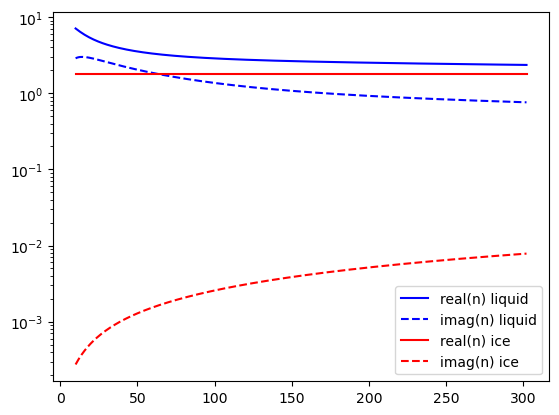

In [13]:
from refraction import complex_n_water_liebe93
from refraction import complex_n_ice_matzler06
import matplotlib.pyplot as plt
freq=np.linspace(10,302,302)
t=273
n_liq = complex_n_water_liebe93(freq,t)
n_ice =complex_n_ice_matzler06(freq,t)

plt.plot(freq,n_liq[:,0],'b',label='real(n) liquid')
plt.plot(freq,n_liq[:,1],'--b',label='imag(n) liquid')

plt.plot(freq,n_ice[:,0],'r',label='real(n) ice')
plt.plot(freq,n_ice[:,1],'--r',label='imag(n) ice')

plt.yscale('log')
plt.legend()

## Size Parameters
Size Parameter $x$
The sphere size relative to the wavelength is called the size parameter $x$ $$ x = 2\pi {r/\lambda} $$ where $r$ is the radius of the sphere.

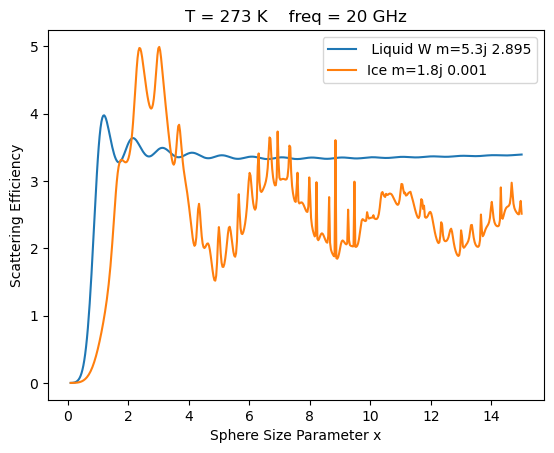

In [14]:
N=500
freq=[20]
t=273

x = np.linspace(0.1,15,N)  # also in microns
n_liq =complex_n_water_liebe93(freq,t)

qext, qsca, qback, g = miepython.mie(n_liq[0,0]+1j*n_liq[0,1],x)
plt.plot(x,qsca,  label=" Liquid W m=%.1f" % (n_liq[0,0]) + 'j %.3f' % (n_liq[0,1]))


n_ice =complex_n_ice_matzler06(freq,t)

qext, qsca, qback, g = miepython.mie(n_ice[0,0]+1j*n_ice[0,1],x)
plt.plot(x,qsca,  label="Ice m=%.1f" % (n_ice[0,0]) + 'j %.3f' % (n_ice[0,1]))

plt.xlabel("Sphere Size Parameter x")
plt.ylabel("Scattering Efficiency")
plt.legend()
plt.title("T = %.0f K" % (t) + "    freq = %.0f GHz" % (freq[0]) )
plt.show()

## Compare Mie and Rayleigh

Comparison of the phase function for small x

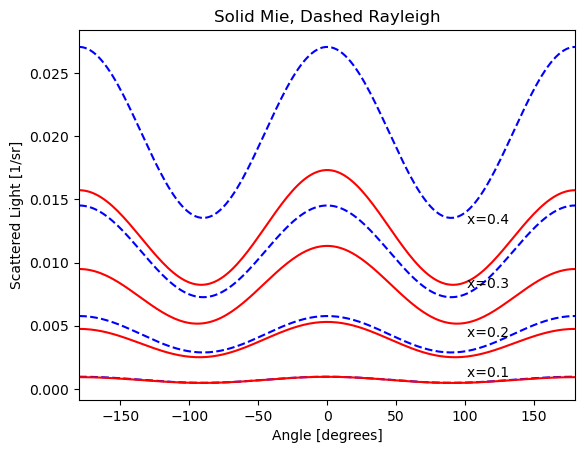

In [16]:
freq=[20]
t=273
n_liq =complex_n_water_liebe93(freq,t)
m=n_liq[0,0]-1j*n_liq[0,1]

for x in [0.1,0.2,0.3,0.4]:

   
    theta = np.linspace(-180,180,180)
    mu = np.cos(theta*np.pi/180)

    rscat = rayleigh_unpolarized(m,x,mu)
    mscat = miepython.i_unpolarized(m,x,mu)
    plt.plot(theta,rscat,'--b')
    plt.plot(theta,mscat,'r')
    plt.annotate('x=%.1f   '%x,(theta[-20],mscat[-20]),ha='right',va='bottom')

plt.xlim(-180,180)
plt.xlabel('Angle [degrees]')
plt.ylabel('Scattered Light [1/sr]')
plt.title('Solid Mie, Dashed Rayleigh')
plt.show()

# polar plots of the phase function

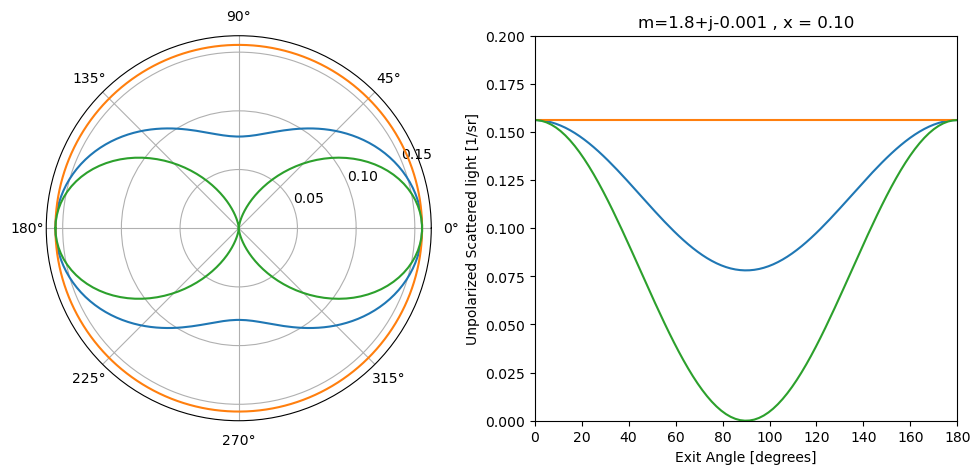

In [9]:
freq=[20]
t=273
n_ice =complex_n_ice_matzler06(freq,t)
m=n_ice[0,0]-1j*n_ice[0,1]

x = 0.1
theta = np.linspace(-180,180,180)
mu = np.cos(theta/180*np.pi)
unp = rayleigh_unpolarized(m,x,mu)
s1,s2 = rayleigh_S1_S2(m,x,mu)
par = abs(s1)**2
per = abs(s2)**2

fig,ax = plt.subplots(1,2,figsize=(12,5))
ax=plt.subplot(121, projection='polar')
ax.plot(theta/180*np.pi,unp)
ax.plot(theta/180*np.pi,par)
ax.plot(theta/180*np.pi,per)

ax.set_rticks([0.05, 0.1,0.15]) 

plt.subplot(122)
#plt.plot(theta,scat)
plt.plot(theta,unp)
plt.plot(theta,par)
plt.plot(theta,per)

plt.xlabel('Exit Angle [degrees]')
plt.ylabel('Unpolarized Scattered light [1/sr]')
plt.title("m=%.1f"%np.real(m)  + "+j%.3f"%np.imag(m) +" , x = %.2f"%x)

plt.ylim(0.00,0.2)
plt.xlim(0,180)

plt.show()

## Absoprtion versus scattering


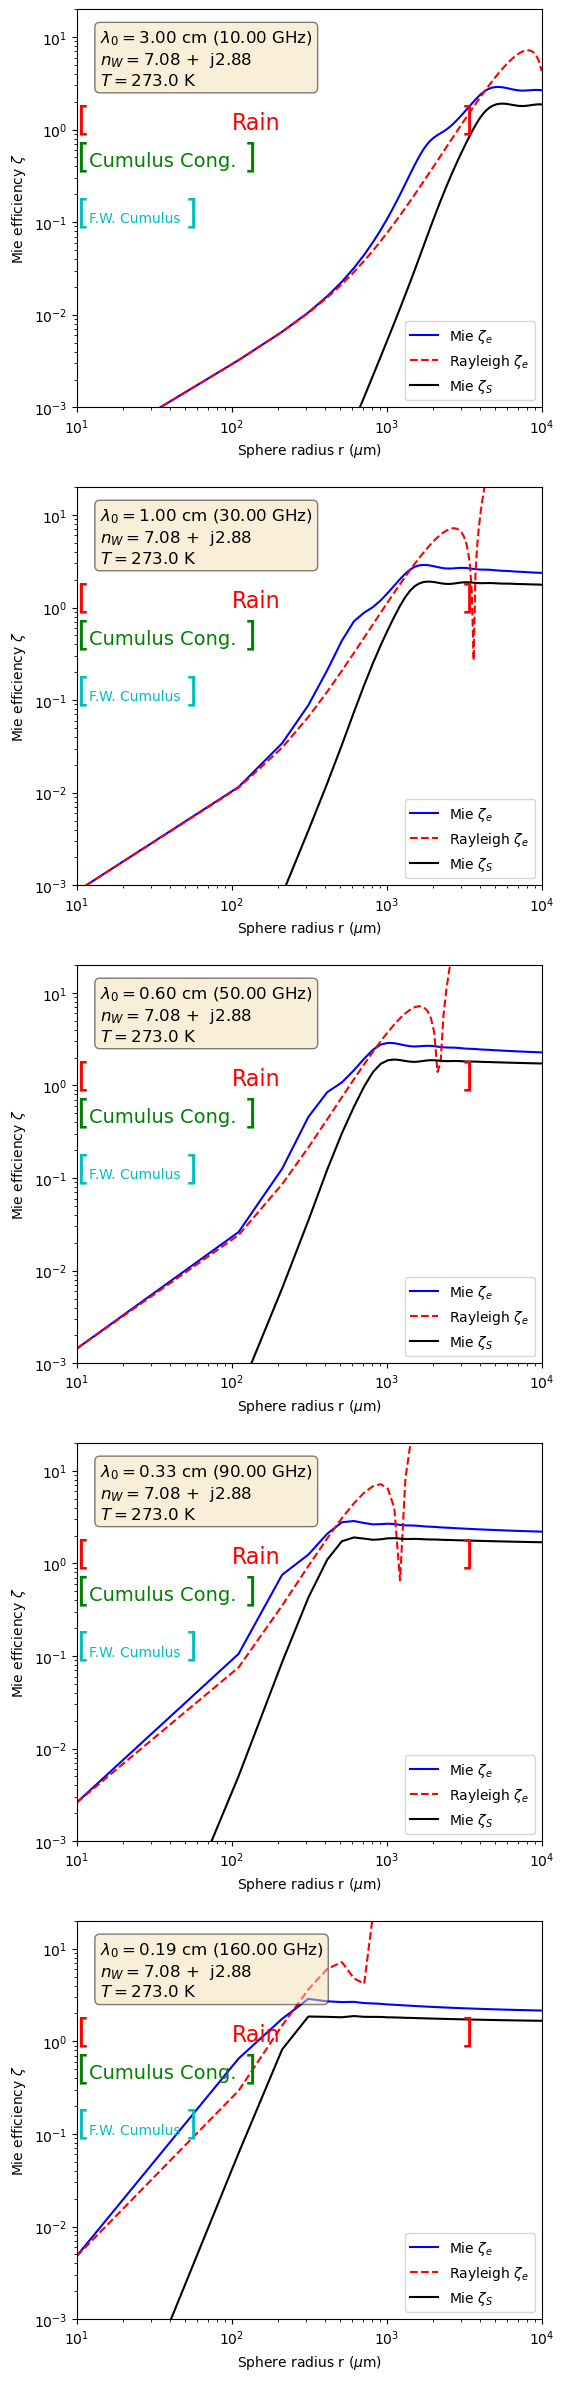

In [38]:
from refraction import complex_n_water_liebe93
import numpy as np
    
import matplotlib.pyplot as plt




freq=np.array([10, 30, 50, 90, 160])  #in GHz 
fig, axs = plt.subplots(len(freq),figsize=(6, 30))
t=273.
n = complex_n_water_liebe93(freq,t)
part_radius = np.linspace(10e-6,10000e-6,100)  # radius size in m it is from 10 micron to 10 cm
c =  299792458 #speed of light in vauum in m / s

for iv in range(len(freq)):
    wavelenght = c/(freq[iv]*1e9)
    x =2*np.pi*part_radius / wavelenght



    mieext=np.zeros((np.shape(x)))
    miesca=np.zeros((np.shape(x)))
    miebak=np.zeros((np.shape(x)))
    mieg=np.zeros((np.shape(x)))

    rayext=np.zeros((np.shape(x)))
    raysca=np.zeros((np.shape(x)))
    raybak=np.zeros((np.shape(x)))
    rayg=np.zeros((np.shape(x)))

    for ix in range(len(x)):
        n1=n[0,0]-1j*np.abs(n[0,1])
        x1=x[ix]
        mieext[ix],miesca[ix],miebak[ix],mieg[ix]=miepython.mie(n1,x1)  

        rayext[ix],raysca[ix],raybak[ix],rayg[ix]=rayleigh(n1,x1)
    

    axs[iv].plot(part_radius*1e+6,mieext,'b',label='Mie $\zeta_e$')
    axs[iv].plot(part_radius*1e+6,rayext,'--r',label='Rayleigh $\zeta_e$')
    axs[iv].plot(part_radius*1e+6,miesca,'k',label='Mie $\zeta_S$')
    axs[iv].set_yscale('log')
    axs[iv].set_xscale('log')
    axs[iv].set_xlim([10,10000])
    axs[iv].set_ylim([1e-3,20])
    axs[iv].set_xlabel('Sphere radius r ($\mu$m)')
    axs[iv].set_ylabel('Mie efficiency $\zeta$')


    textstr = '\n'.join((
        r'$\lambda_0 = %.2f$ cm' % (wavelenght*100, ) + r' (%.2f GHz)' % (freq[iv],),
        r'$n_W = %.2f$ + ' % (n[0,0], ) + r' j%.2f' % (n[0,1],),
        r'$T = %.1f$ K' % (t, )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    axs[iv].text(0.05, 0.95, textstr, transform=axs[iv].transAxes, fontsize=12,
            verticalalignment='top', bbox=props)
    axs[iv].legend(loc= 'lower right')
    axs[iv].annotate("[", xy=(10, 1),size=24,color='r')
    axs[iv].annotate("Rain", xy=(1e2,1), size=16,color='r')
    axs[iv].annotate("]", xy=(3e3,1), size=24,color='r')
    
    axs[iv].annotate("[", xy=(10, .4),size=24,color='g')
    axs[iv].annotate("Cumulus Cong.", xy=(1.2e1,.4), size=14,color='g')
    axs[iv].annotate("]", xy=(1.2e2,.4), size=24,color='g')
    
    axs[iv].annotate("[", xy=(10, .1),size=24,color='c')
    axs[iv].annotate("F.W. Cumulus", xy=(1.2e1,.1), size=10,color='c')
    axs[iv].annotate("]", xy=(5e1,.1), size=24,color='c')
    
    #axs[iv].plot([0,3e3],1,'r',


These plots for some important frequencies in passive microwave imaging shows:
1) the range of validity of the Rayleigh regime (when the red dotted curve is not aligned with the blue one the Raylegh scattering is not accurate)
2) The particle size where the absorption dominates over scattering (if the extintion is strongly higher than scattering absorption dominates), in ralation to the sizes os some hyrometeors (intense Rain, Cumulus Congestus - moderate rain, and Fair Weather Cumulus a cloud without rain)

for Fair weather cumulus absorption dominates over scattering even at 160 GHz, however at this frequency the Rayleigh scattering is not a good approximation. Rain shows more absorption than scattering anly at 10 GHz, for higher frequencies scattering becomes dominant for the larger particles.

## Excercize:

try to calculate plot similar to the the one of the previous cell for the ice case (use the complex_n_ice_matzler06 function).
Do not take into account the Raylegh scattering (eliminate the red curve) and consider to modify the figure border:

axs[iv].set_ylim([1e-7,20])

and comment:

When (for what frequencies and sizes) absorption dominates over scattering? Why that happens? (think about the refractive index)


#### some theorical questions:

**when absorption dominates over scattering we expect higher or lower brightness temperatures (with respect to the clear sky case)?**

**when scattering dominates we expect higher or lower brightness temperatures (with respect to the clear sky case)?**

